In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== Synthetic Data ==========
def generate_transformed_dataset():
    x1_vals = np.linspace(0, 2, 30)
    x2_vals = np.linspace(-0.9, 0.9, 30)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    def psi(x1, x2):
        return np.exp(x1) * np.cos(x2), np.exp(x1) * np.sin(x2)

    Y1, Y2 = psi(X1_flat, X2_flat)
    X_np = np.stack([X1_flat, X2_flat], axis=1)
    Y_np = np.stack([Y1, Y2], axis=1)

    X = torch.tensor(X_np, dtype=torch.float32)
    Y = torch.tensor(Y_np, dtype=torch.float32)
    return X, Y

class TransformedDatasetLoader:
    def __init__(self, X, Y, batch_size=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.Y[idx]

# ========== FBM Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

def generate_fbm_bias_tensor(L, n, H):
    V = np.zeros((L, n))
    for i in range(n):
        fbm_path = generate_fbm_path(H, L)
        increments = np.diff(fbm_path)
        V[:, i] = (L**H) * increments
    return torch.tensor(V, dtype=torch.float32)

def generate_zero_weight_tensor(L, n):
    return torch.zeros((L, n, n), dtype=torch.float32)

def generate_zero_bias_tensor(L, n):
    return torch.zeros((L, n), dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, V_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.V = nn.Parameter(V_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift + self.scale * self.V
        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out += correction
        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, n, num_layers, beta, W_tensor, V_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, n)
        self.output_layer = nn.Linear(n, input_dim)
        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], V_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)


# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)
    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break
    return train_losses, test_losses

# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)
    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break
    return train_losses, test_losses

# ========== Plotting ==========
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for H, losses in sorted(train_loss_dict.items(), key=lambda x: str(x[0])):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].set_ylim([-2,1])
    axes[0].legend()
    axes[0].grid(True)

    for H, losses in sorted(test_loss_dict.items(), key=lambda x: str(x[0])):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].set_ylim([0,1])
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
L = 100
n = 10
epochs = 2000
log_interval = 50
n_runs = 10

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}
test_losses_corr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
test_losses_nocorr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
train_losses_zero = {"zero": np.zeros(epochs)}
test_losses_zero = {"zero": np.zeros(epochs // log_interval + 1)}

# Dataset
X, Y = generate_transformed_dataset()
perm = torch.randperm(X.size(0))
X_train, Y_train = X[perm[:800]], Y[perm[:800]]
X_test, Y_test = X[perm[800:]], Y[perm[800:]]

train_loader = TransformedDatasetLoader(X_train.to(device), Y_train.to(device), batch_size=1)
test_loader = TransformedDatasetLoader(X_test.to(device), Y_test.to(device), batch_size=64)

# Main loop
for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)
        V_tensor = generate_fbm_bias_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(2, n, L, H, W_tensor, V_tensor, apply_correction=False)
        losses_nocorr, test_nocorr = train_single_point_model(model_nocorr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_nocorr[H] += np.array(losses_nocorr)
        test_losses_nocorr[H] += np.array(test_nocorr)

        # With correction
        model_corr = FBMResNet(2, n, L, H, W_tensor, V_tensor, apply_correction=True)
        losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_corr[H] += np.array(losses_corr)
        test_losses_corr[H] += np.array(test_corr)

    # === Zero Init ===
    W_tensor_zero = generate_zero_weight_tensor(L, n)
    V_tensor_zero = generate_zero_bias_tensor(L, n)
    model_zero = FBMResNet(2, n, L, beta=0.5, W_tensor=W_tensor_zero, V_tensor=V_tensor_zero, apply_correction=False)
    losses_zero, test_zero = train_single_point_model(model_zero, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
    train_losses_zero["zero"] += np.array(losses_zero)
    test_losses_zero["zero"] += np.array(test_zero)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    test_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs
    test_losses_corr[H] /= n_runs

train_losses_zero["zero"] /= n_runs
test_losses_zero["zero"] /= n_runs

# Plot
plot_loss_curves({**train_losses_nocorr, **train_losses_zero},
                 {**test_losses_nocorr, **test_losses_zero},
                 "No Correction + Zero Init (Averaged)", log_interval)

plot_loss_curves({**train_losses_corr, **train_losses_zero},
                 {**test_losses_corr, **test_losses_zero},
                 "With Correction + Zero Init (Averaged)", log_interval)


Averaging over runs:   0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [2]:
def plot_diffeomorphism_comparison(model, X_train, Y_train, X_test, Y_test, train_loss, test_loss, log_interval):
    model.eval()
    with torch.no_grad():
        pred_train = model(X_train.to(device)).cpu()
        pred_test = model(X_test.to(device)).cpu()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(Y_train[:, 0], Y_train[:, 1], color='blue', marker='o', label='Original')
    axes[0].scatter(pred_train[:, 0], pred_train[:, 1], color='red', marker='o', label='Approximated')
    axes[0].set_title("Approximated diffeomorphism: training dataset")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].scatter(Y_test[:, 0], Y_test[:, 1], color='blue', marker='x', label='Correct')
    axes[1].scatter(pred_test[:, 0], pred_test[:, 1], color='red', marker='x', label='Predicted')
    axes[1].set_title("Approximated diffeomorphism: testing dataset")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(np.log10(train_loss), label='Training error', linestyle='--')
    axes[2].plot(np.arange(len(test_loss)) * log_interval, test_loss, label='Testing error')
    axes[2].hlines(y=max(test_loss), xmin=0, xmax=len(train_loss), colors='magenta', linestyles='dotted', label='Generalization error estimate')
    axes[2].set_title("Decrease of training and testing error")
    axes[2].set_xlabel("Iteration")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


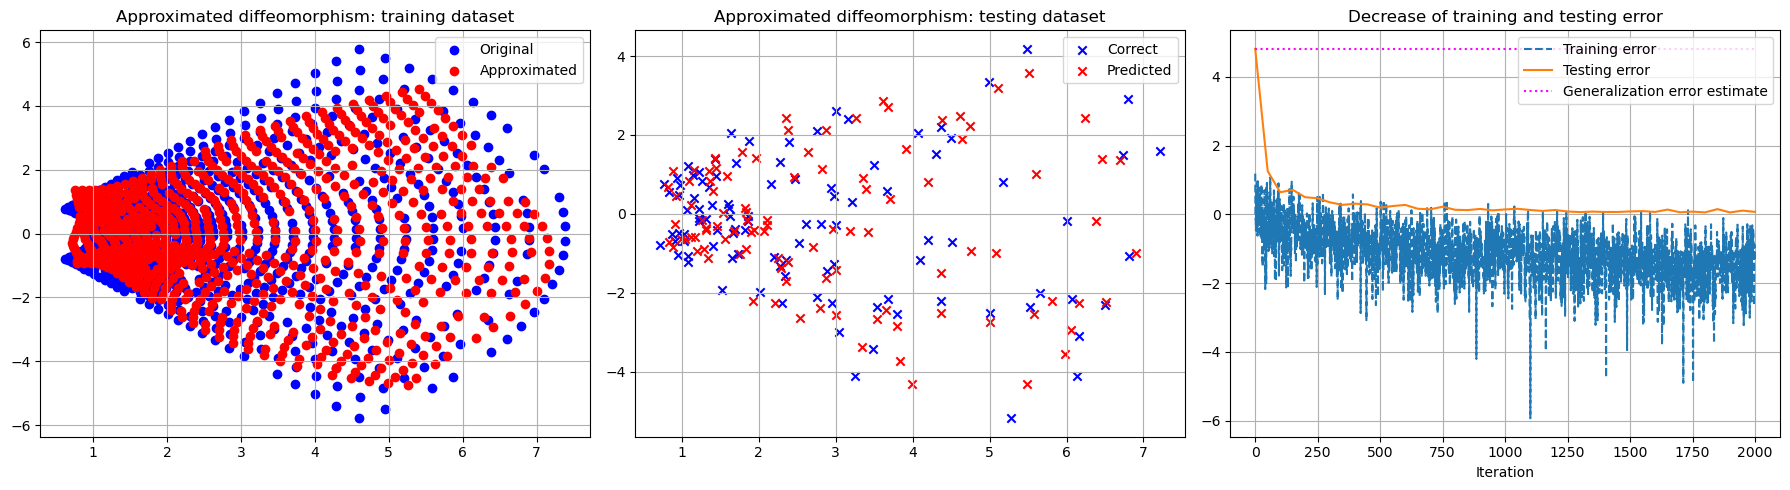

In [3]:
H = 0.2
W_tensor = generate_fbm_weight_tensor(L, n, H=H)
V_tensor = generate_fbm_bias_tensor(L, n, H=H)

model_corr = FBMResNet(2, n, L, H, W_tensor, V_tensor, apply_correction=True)

losses_corr, test_corr = train_single_point_model(
    model_corr, train_loader, test_loader,
    epochs=epochs, lr=0.1 * n / L, log_interval=log_interval
)

# Visualize diffeomorphism approximation for H = 0.2
plot_diffeomorphism_comparison(
    model_corr, X_train, Y_train, X_test, Y_test,
    losses_corr, test_corr, log_interval
)

Averaging over runs:   0%|          | 0/10 [00:00<?, ?it/s]

Averaging over runs: 100%|██████████| 10/10 [56:48<00:00, 340.87s/it]


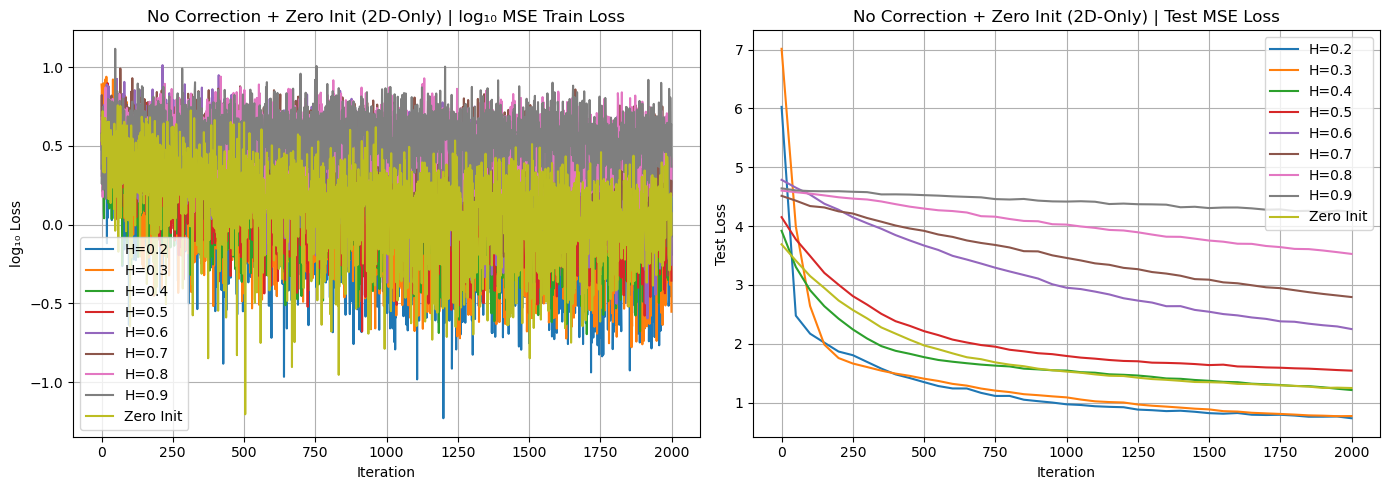

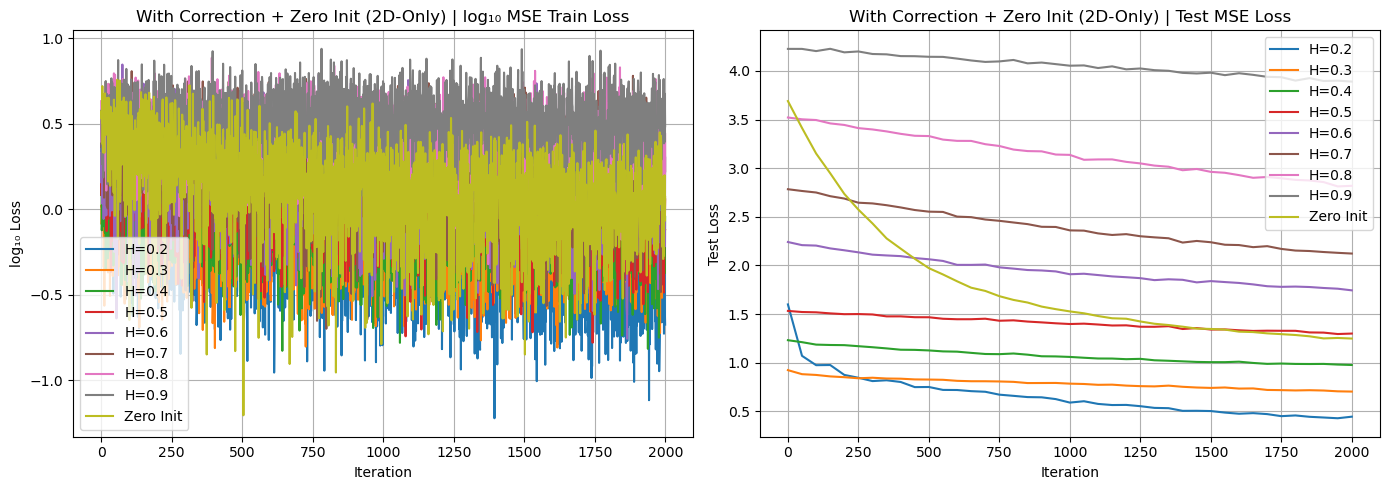

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== Synthetic Data ==========
def generate_transformed_dataset():
    x1_vals = np.linspace(0, 2, 30)
    x2_vals = np.linspace(-0.9, 0.9, 30)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    def psi(x1, x2):
        return np.exp(x1) * np.cos(x2), np.exp(x1) * np.sin(x2)

    Y1, Y2 = psi(X1_flat, X2_flat)
    X_np = np.stack([X1_flat, X2_flat], axis=1)
    Y_np = np.stack([Y1, Y2], axis=1)

    X = torch.tensor(X_np, dtype=torch.float32)
    Y = torch.tensor(Y_np, dtype=torch.float32)
    return X, Y

class TransformedDatasetLoader:
    def __init__(self, X, Y, batch_size=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.Y[idx]

# ========== FBM Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

def generate_fbm_bias_tensor(L, n, H):
    V = np.zeros((L, n))
    for i in range(n):
        fbm_path = generate_fbm_path(H, L)
        increments = np.diff(fbm_path)
        V[:, i] = (L**H) * increments
    return torch.tensor(V, dtype=torch.float32)

def generate_zero_weight_tensor(L, n):
    return torch.zeros((L, n, n), dtype=torch.float32)

def generate_zero_bias_tensor(L, n):
    return torch.zeros((L, n), dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, V_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=True)
        self.V = nn.Parameter(V_k, requires_grad=True)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift + self.scale * self.V
        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out += correction
        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, num_layers, beta, W_tensor, V_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Identity()
        self.output_layer = nn.Identity()
        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], V_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)
    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break
    return train_losses, test_losses

# ========== Plotting ==========
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for H, losses in sorted(train_loss_dict.items(), key=lambda x: str(x[0])):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].grid(True)

    for H, losses in sorted(test_loss_dict.items(), key=lambda x: str(x[0])):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
L = 100
n = 2  # Only 2D dynamics
epochs = 2000
log_interval = 50
n_runs = 10

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}
test_losses_corr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
test_losses_nocorr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
train_losses_zero = {"zero": np.zeros(epochs)}
test_losses_zero = {"zero": np.zeros(epochs // log_interval + 1)}

# Dataset
X, Y = generate_transformed_dataset()
perm = torch.randperm(X.size(0))
X_train, Y_train = X[perm[:800]], Y[perm[:800]]
X_test, Y_test = X[perm[800:]], Y[perm[800:]]

train_loader = TransformedDatasetLoader(X_train.to(device), Y_train.to(device), batch_size=1)
test_loader = TransformedDatasetLoader(X_test.to(device), Y_test.to(device), batch_size=64)

# Main loop
for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)
        V_tensor = generate_fbm_bias_tensor(L, n, H=H)

        model_nocorr = FBMResNet(2, L, H, W_tensor, V_tensor, apply_correction=False)
        losses_nocorr, test_nocorr = train_single_point_model(model_nocorr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_nocorr[H] += np.array(losses_nocorr)
        test_losses_nocorr[H] += np.array(test_nocorr)

        model_corr = FBMResNet(2, L, H, W_tensor, V_tensor, apply_correction=True)
        losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_corr[H] += np.array(losses_corr)
        test_losses_corr[H] += np.array(test_corr)

    # Zero Init
    W_tensor_zero = generate_zero_weight_tensor(L, n)
    V_tensor_zero = generate_zero_bias_tensor(L, n)
    model_zero = FBMResNet(2, L, beta=0.5, W_tensor=W_tensor_zero, V_tensor=V_tensor_zero, apply_correction=False)
    losses_zero, test_zero = train_single_point_model(model_zero, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
    train_losses_zero["zero"] += np.array(losses_zero)
    test_losses_zero["zero"] += np.array(test_zero)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    test_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs
    test_losses_corr[H] /= n_runs

train_losses_zero["zero"] /= n_runs
test_losses_zero["zero"] /= n_runs

# Plot
plot_loss_curves({**train_losses_nocorr, **train_losses_zero},
                 {**test_losses_nocorr, **test_losses_zero},
                 "No Correction + Zero Init (2D-Only)", log_interval)

plot_loss_curves({**train_losses_corr, **train_losses_zero},
                 {**test_losses_corr, **test_losses_zero},
                 "With Correction + Zero Init (2D-Only)", log_interval)


In [8]:
def plot_diffeomorphism_comparison(model, X_train, Y_train, X_test, Y_test, train_loss, test_loss, log_interval):
    model.eval()
    with torch.no_grad():
        pred_train = model(X_train.to(device)).cpu()
        pred_test = model(X_test.to(device)).cpu()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(Y_train[:, 0], Y_train[:, 1], color='blue', marker='o', label='Original')
    axes[0].scatter(pred_train[:, 0], pred_train[:, 1], color='red', marker='o', label='Approximated')
    axes[0].set_title("Approximated diffeomorphism: training dataset")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].scatter(Y_test[:, 0], Y_test[:, 1], color='blue', marker='x', label='Correct')
    axes[1].scatter(pred_test[:, 0], pred_test[:, 1], color='red', marker='x', label='Predicted')
    axes[1].set_title("Approximated diffeomorphism: testing dataset")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(np.log10(train_loss), label='Training error', linestyle='--')
    axes[2].plot(np.arange(len(test_loss)) * log_interval, test_loss, label='Testing error')
    axes[2].hlines(y=max(test_loss), xmin=0, xmax=len(train_loss), colors='magenta', linestyles='dotted', label='Generalization error estimate')
    axes[2].set_title("Decrease of training and testing error")
    axes[2].set_xlabel("Iteration")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

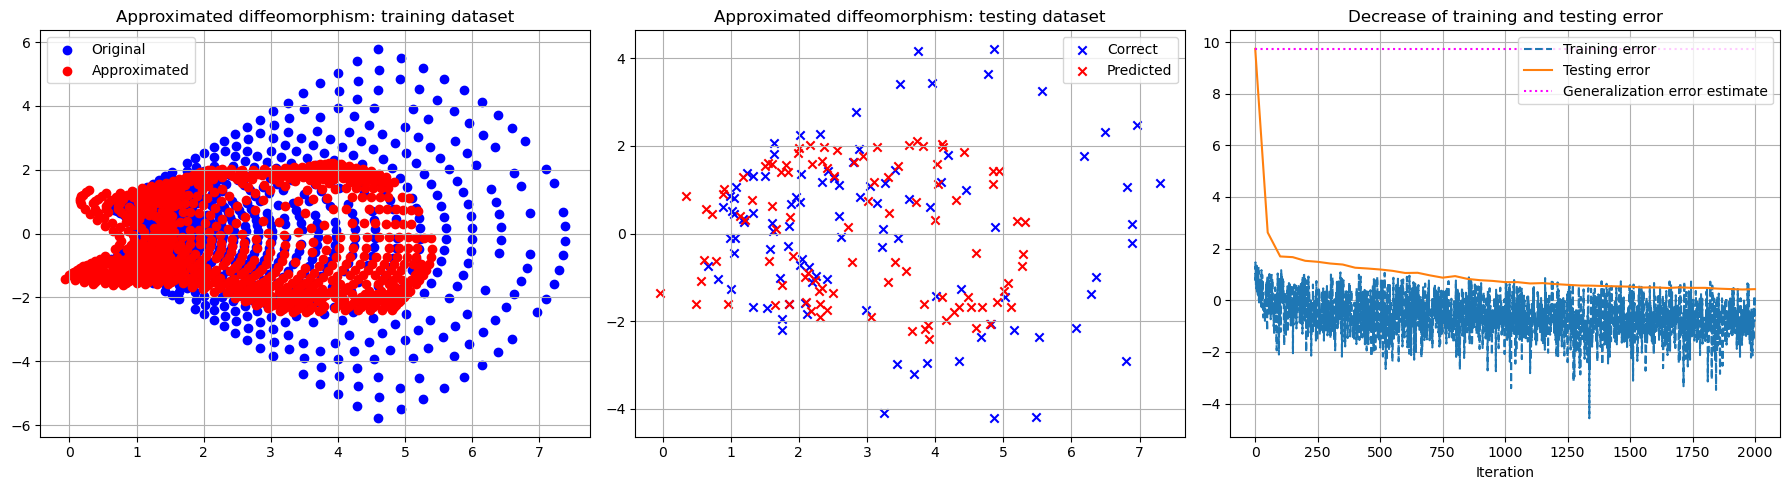

In [9]:
H = 0.2
n = 2  # important for 2D-only setup

W_tensor = generate_fbm_weight_tensor(L, n, H=H)
V_tensor = generate_fbm_bias_tensor(L, n, H=H)

model_corr = FBMResNet(
    input_dim=2,
    num_layers=L,
    beta=H,
    W_tensor=W_tensor,
    V_tensor=V_tensor,
    apply_correction=True
)

losses_corr, test_corr = train_single_point_model(
    model_corr, train_loader, test_loader,
    epochs=epochs, lr=0.1 * n / L, log_interval=log_interval
)

plot_diffeomorphism_comparison(
    model_corr, X_train, Y_train, X_test, Y_test,
    losses_corr, test_corr, log_interval
)